In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler

import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.io import savemat,loadmat
import scipy.integrate as integrate
# %matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.animation as animation 
# get_ipython().run_line_magic('matplotlib', 'inline')

from itertools import combinations_with_replacement, product
from sklearn.decomposition import SparseCoder
from tqdm.notebook import tqdm,trange
import sys,time
import os
import copy
import pickle
from IPython.display import HTML

import pysindy as ps

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Fri Aug  6 21:11:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   44C    P0    55W / 300W |  15288MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   46C    P0    56W / 300W |    430MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Discover Latent Space Dynamics

In [3]:
%cd
example = 9
training_value = 7
LS_dim = 4
# ### Load Data if Model Already Exists ###
snapshot_full = np.load('./SALDI/Ex9/data/ex{}_{}.npz'.format(example, training_value), allow_pickle = True)
snapshot_full = snapshot_full.f.arr_0

nx = 64
ny = 64
m = (ny-2)*(nx-2) # 3364
nt = 239
tstop = 3
dt = tstop/nt

/g/g15/fries4


In [4]:
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

snapshot_full = snapshot_full[:,free_raveled_indicies]

[xv,yv]=np.meshgrid(np.linspace(-1,1,nx),np.linspace(-1,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

In [5]:
# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

model = torch.load('../../../../../usr/WS1/fries4/Experiments/EX9/model/ex{}_4_AE_{}.tar'.format(example, LS_dim), map_location=device)    

maxk = 10
convergence_threshold = 1.0e-8

t = np.linspace(0, tstop, nt)

# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer
f = LS_dim


def create_mask_2d(m,b,db):

    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1

#     col_ind=np.array([],dtype='int')
#     row_ind=np.array([],dtype='int')

#     for lin_ind in range(m):
#         j,i=np.unravel_index(lin_ind,(ny-2,nx-2))

#         E=np.ravel_multi_index((j,np.max((i-1,0))),(ny-2,nx-2))
#         W=np.ravel_multi_index((j,np.min((i+1,nx-2-1))),(ny-2,nx-2))
#         S=np.ravel_multi_index((np.max((j-1,0)),i),(ny-2,nx-2))
#         N=np.ravel_multi_index((np.min((j+1,ny-2-1)),i),(ny-2,nx-2))

#         col=np.unique([lin_ind,E,W,S,N])
#         row=lin_ind*np.ones(col.size,dtype='int')

#         col_ind=np.append(col_ind,col)
#         row_ind=np.append(row_ind,row)

#     data=np.ones(row_ind.size,dtype='int')
#     local2=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,m))

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block

    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()

    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )

#         plt.figure()
#         plt.spy(mask)
#         plt.show()

    return mask



class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            nn.Sigmoid(),
            nn.Linear(M1,f,bias=False)
        )

    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()

        return T

class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2),
            nn.Sigmoid(),
            nn.Linear(M2,m,bias=False)
        )

    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()

        return y

encoder = Encoder(m,M1,f).to(device)
decoder = Decoder(f,M2,m).to(device)
# Prune
mask_2d=create_mask_2d(m,b,db)
prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))  

loss_func = nn.MSELoss(reduction='mean')

encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

Using device: cuda 

Sparsity in 3844 by 38530 mask: 99.18%


<All keys matched successfully>

In [6]:
amp_arr = np.linspace(.6,.9,training_value)
width_arr = np.array([1])

P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

latent_space_SS = []

for foo in range(nset):
    input_SS=torch.tensor(snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].astype('float32')).to(device)
    latent_space = encoder(input_SS).cpu().detach().numpy()
    latent_space_SS.append(latent_space)

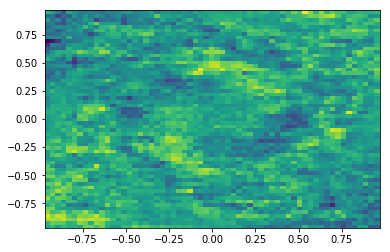

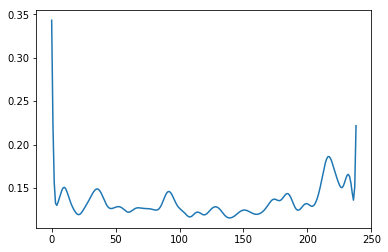

In [7]:
recon = decoder(encoder(input_SS)).cpu().detach().numpy()
u_full = snapshot_full[foo*(nt+1):(foo+1)*(nt+1)]
k=-1
fig = plt.figure()
z=plt.pcolormesh(x_free.reshape(nx-2,ny-2),y_free.reshape(nx-2,ny-2),recon[k].reshape(nx-2,ny-2)-u_full[k].reshape(nx-2,ny-2), shading = 'nearest')
test = []
for k in range(int(nt)):
    test.append(LA.norm(recon[k].reshape(ny-2,nx-2)-u_full[k].reshape(ny-2,nx-2))/LA.norm(u_full[k].reshape(ny-2,nx-2))*100)
fig = plt.figure()
plt.plot(test)

In [8]:
degree = 3
# normal = 1
normal = np.amax(np.abs(latent_space_SS))
data = []
for i in range(nset):
    data.append(latent_space_SS[i]/normal)

In [9]:
poly_library = ps.PolynomialLibrary(include_interaction=False, degree = degree)
optim = ps.STLSQ(threshold=0.1, alpha=0.1, copy_X=True, fit_intercept=False, max_iter=20, normalize=False, ridge_kw=None)
model_PS = ps.SINDy(feature_library = poly_library, optimizer = optim)
model_PS.fit(data, t = dt, multiple_trajectories = True, quiet = True)
model_PS.print()

x0' = 0.148 1 + 0.640 x0 + 1.284 x1 + -0.583 x2 + -0.473 x3 + -2.601 x0^2 + -4.051 x1^2 + -0.915 x2^2 + 1.160 x3^2 + 1.947 x0^3 + 2.775 x1^3 + -1.735 x2^3 + -1.599 x3^3
x1' = -0.218 x0 + 0.208 x1 + 0.260 x3 + -1.082 x2^2 + 0.916 x3^2 + -0.307 x1^3 + -0.736 x2^3 + -0.877 x3^3
x2' = 0.013 1 + 1.100 x0 + 0.547 x1 + -0.445 x2 + -1.856 x0^2 + -1.285 x2^2 + 1.796 x0^3 + -0.612 x1^3 + -1.728 x2^3 + -0.411 x3^3
x3' = 0.380 1 + 0.159 x0 + -0.306 x1 + 0.681 x2 + -0.273 x3 + 0.086 x2^2 + 0.451 x3^2 + -0.156 x0^3 + -0.471 x2^3


In [10]:
L = np.empty([len(data),f])
for i in range(len(data)):
    L[i,:] = data[i][0]
B = LA.lstsq(P, L, rcond = None)[0].T

## Test Dynamics on Training Set

In [11]:
Max_Error = 0
for i in range(len(data)):
    X_sim = model_PS.simulate(data[i][0], t)
    Error = LA.norm((X_sim-data[i][:-1])**2/np.prod(X_sim.shape))
    if Error > Max_Error:
        Max_Error = Error
    print("MSE for Simulation {}: {}".format(i, Error))
print("")
print('Max MSE: {}'.format(Max_Error))


MSE for Simulation 0: 2.8885104594114457e-06
MSE for Simulation 1: 3.2005853015108543e-06
MSE for Simulation 2: 2.983711256251037e-06
MSE for Simulation 3: 1.6171463679013914e-06
MSE for Simulation 4: 9.026226806694539e-07
MSE for Simulation 5: 5.75925755937201e-07
MSE for Simulation 6: 3.273304977455095e-06

Max MSE: 3.273304977455095e-06


/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x200282899550> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2002828996a0> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x2002828997f0> has a label of '_nolegend' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/usr/tce/packages/python/python-3.7.2/lib/python3.7/site-packages/matplotlib/legend.py:449: UserWarning: The handle <matplotlib.lines.Line2D object at 0x20027f4

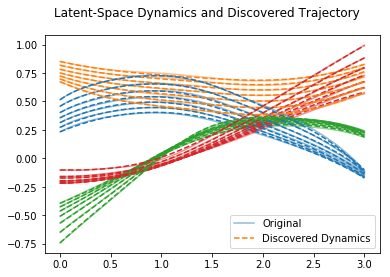

In [12]:
fig = plt.figure()
fig.suptitle('Latent-Space Dynamics and Discovered Trajectory')
ax = plt.axes()

for i in range(len(data)):
    ax.plot(t,data[i][:-1], alpha = .5)
    X_sim = model_PS.simulate(data[i][0], t)
    plt.gca().set_prop_cycle(None)
    ax.plot(t,X_sim[:],'--')
    plt.gca().set_prop_cycle(None)
labels = ['Original', '_nolegend','_nolegend','_nolegend','_nolegend', 'Discovered Dynamics']
ax.legend(labels)

## Test Dynamics on Interpolated and Extrapolated Parameters (long run-time)

In [26]:
amp = np.arange(.6,.9,.01)
max_re_approx= np.zeros(len(amp))
max_re_exact = np.zeros(len(amp))
speed_up = np.zeros([2,len(amp)])
speed_up_avg = np.empty([2,training_value-1])
adapt_values = np.empty([4,training_value-1])
row_count = -1

for ii in [4]:
    row_count = -1
    for a in amp:
        row_count += 1
        Save = np.load('../../../../../usr/WS1/fries4/Experiments/EX9/data/Interp_Extrap/ex9_{}.p'.format(int(a*100)), allow_pickle = True)
        FOM = Save['FOM']
        FOM = FOM[:,free_raveled_indicies]
        time_FOM = Save['t']



       ##########################################################################
       #### Uncomment this section to use k-closest training points in model ####
       #### [Specify k below]                                                ####

        dist = np.empty(P.shape[0])
        for i in range(P.shape[0]):
            dist[i]=(LA.norm(P[i]-np.array([a,1])))

        k=ii

        dist_index = np.argsort(dist)[0:k]
        L = np.empty([k,f])

        local = []
        j=-1
        for i in dist_index:
            j+=1
            L[j,:] = data[i][0]
            local.append(data[i])

        B = LA.lstsq(np.array(P[dist_index]), L, rcond = None)[0].T
        model_PS.fit(local, t = dt, multiple_trajectories = True, quiet = True)

       ###########################################################################
        time_SINDy_start = time.time()
        IC = np.matmul(B, np.array([a,1])).reshape(f)
        latent_space_recon = torch.tensor(model_PS.simulate(IC, t).astype('float32')).to(device)
        recon = decoder(latent_space_recon).cpu().detach().numpy()
        time_SINDy_stop = time.time()
        time_SINDy = time_SINDy_stop-time_SINDy_start
        speed_up[0,row_count] = time_FOM/time_SINDy
        test = []
        for i in range(nt):
            test.append(LA.norm(recon[i]-FOM[i,:])/LA.norm(FOM[i,:]))
        max_re_approx[row_count]=np.amax(test)*100

    #     if np.round(a,2) == .66:
    #         plt.plot(test)

        time_SINDy_start = time.time()
        IC = encoder(torch.tensor(FOM[0,:]).to(device)).cpu().detach().numpy()
        latent_space_recon = torch.tensor(model_PS.simulate(IC/normal, t).astype('float32')).to(device)
        recon = decoder(normal*latent_space_recon).cpu().detach().numpy()

        time_SINDy_stop = time.time()
        time_SINDy = time_SINDy_stop-time_SINDy_start
        speed_up[1,row_count] = time_FOM/time_SINDy
        test = []
        for i in range(nt):
            test.append(LA.norm(recon[i]-FOM[i,:])/LA.norm(FOM[i,:]))
    #     if np.round(a,2) == .66:
    #         plt.plot(test)
        max_re_exact[row_count]=np.amax(test)*100

    speed_up_avg[0,ii-2] = np.mean(speed_up[0,:]) 
    speed_up_avg[1,ii-2] = np.mean(speed_up[1,:]) 
    adapt_values[0,ii-2] = np.amin(max_re_approx)
    adapt_values[1,ii-2] = np.amax(max_re_approx)
    adapt_values[2,ii-2] = np.amin(max_re_exact)
    adapt_values[3,ii-2] = np.amax(max_re_exact)

(0.5, 15)

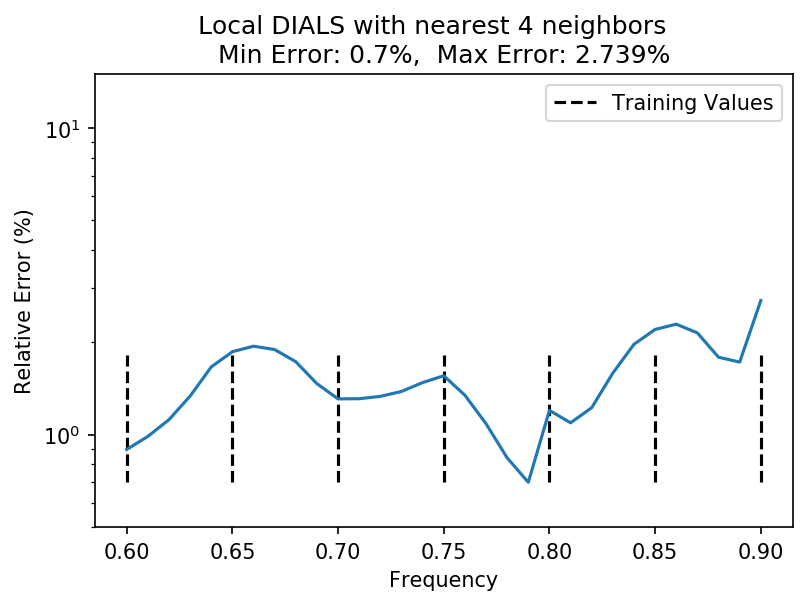

In [27]:
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
amp = np.arange(.6,.9,.01)
for i in amp_arr:
    ax1.plot([i,i], [np.amin(max_re_exact), np.amax(max_re_exact)/1.5], 'k--')
if k<len(data):
    fig.suptitle('Local DIALS with nearest {} neighbors'.format(k))
else:
    fig.suptitle('Global DIALS')
ax1.set_title('Min Error: {:.2}%,  Max Error: {:.5}%'.format(np.amin(max_re_exact), np.amax(max_re_exact)))
# ax1.plot(amp, max_re_approx)
ax1.plot(amp, max_re_exact)
# ax1.legend([ 'Approximate IC. Speed up: {:.0f}'.format(np.mean(speed_up[0])), 'Exact IC. Speed up: {:.0f}'.format(np.mean(speed_up[1])), 'Training Values'])
ax1.legend(['Training Values'])
ax1.set_ylabel('Relative Error (%)')
ax1.set_xlabel('Frequency')
ax1.set_yscale('log')
ax1.set_ylim(.5,15)

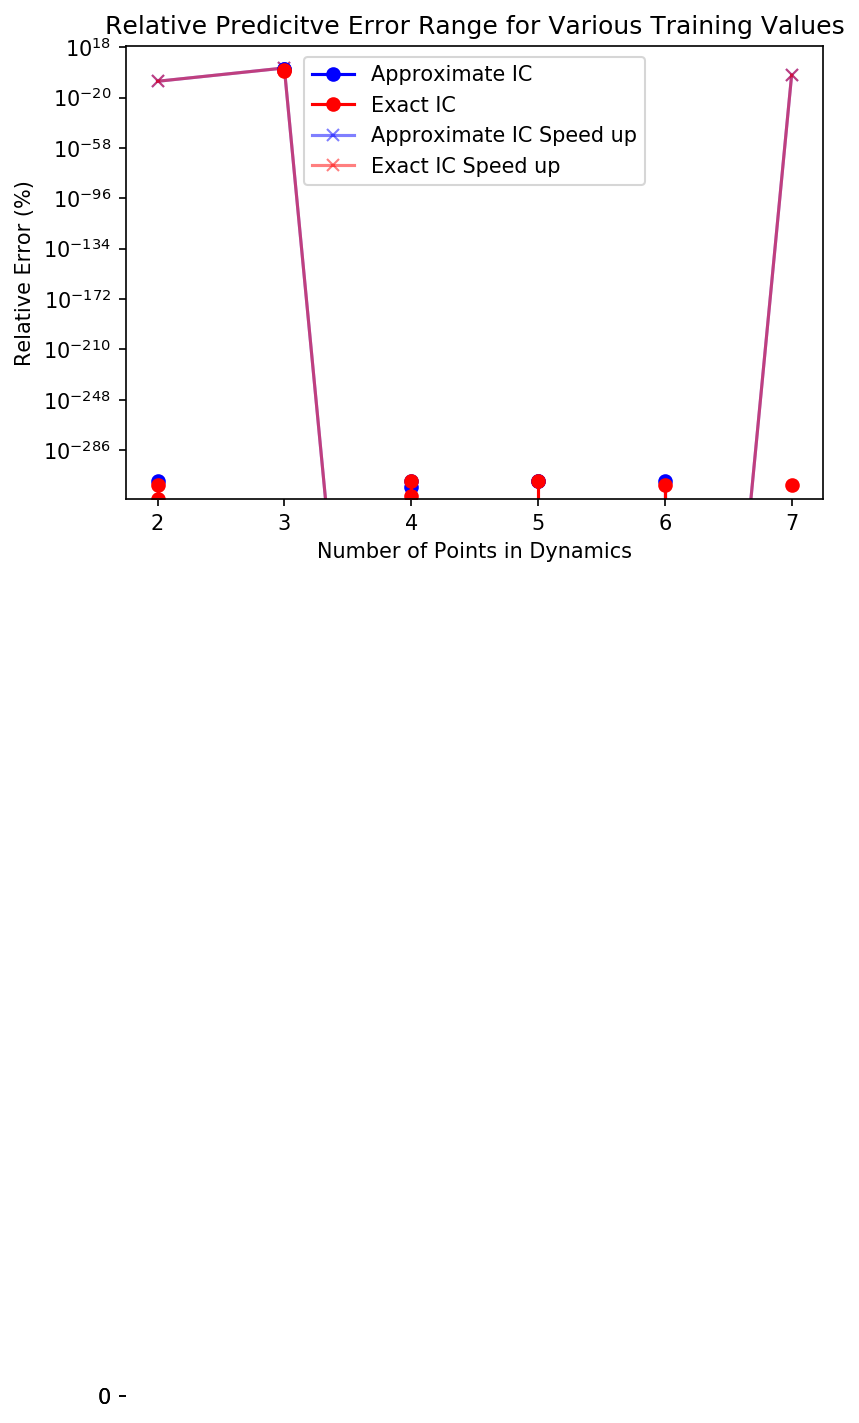

In [15]:
plt.rcParams['figure.dpi'] = 150 
fig = plt.figure()
ax = plt.axes()
for i in range(2,training_value+1):
    ax.plot([i,i], [adapt_values[0,i-2], adapt_values[1,i-2]], 'b-o')
    ax.plot([i,i], [adapt_values[2,i-2], adapt_values[3,i-2]], 'r-o')
    if i == 2:
        ax.plot(np.arange(2,training_value+1), speed_up_avg[0], 'b-x', alpha = .5)
        ax.plot(np.arange(2,training_value+1), speed_up_avg[0],'r-x', alpha = .5)
ax.set_yscale('log')
# ax.set_ylim(.1,1000)
ax.legend(['Approximate IC', 'Exact IC', 'Approximate IC Speed up', 'Exact IC Speed up'])
ax.set_xlabel('Number of Points in Dynamics')
ax.set_ylabel('Relative Error (%)')
ax.set_title('Relative Predicitve Error Range for Various Training Values')
plt.show()

In [16]:
torch.cuda.empty_cache()

In [17]:
# print(np.round(speed_up,2))

In [18]:
np.mean(speed_up[0])

203.61790462995518

In [19]:
np.mean(speed_up[1])

206.37675135619529

In [20]:
15/time_SINDy

184.60086733526205

In [21]:
adapt_values[2,:]

array([1.69759664e-313, 1.09749194e+000, 1.73890251e-310, 1.73833937e-310,
       0.00000000e+000, 1.69759664e-313])